# DL Project
## Stock Market Prediction 
In this project we will try to predict the stock market value using the dataset Stock Market Data of USA. 
We will use the LSTM model to predict the values of future stocks

**Index**: stock market index
**Date**: date of information recorded
**Open**: the price at which a stock starts trading.
**High**: show the high price a stock attained for a particular period of time.
**Low**: show the low price a stock attained for a particular period of time.
**Close**: The close is a reference to the end of a trading session in the financial markets when the markets close for the day
**Adj Close**: It is the price at which the last of the stock is bought or sold in the last trading session.
**Volume**: Volume is simply the number of shares traded in a particular stock, index, or other investment over a specific period of time.




In [ ]:
import pandas as pd

data = pd.read_excel('DL_Dataset.xlsx')

print(data)

In [ ]:
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')  # Converte a coluna 'Date' para datetime

## Retirar duplicados e NA's

In [ ]:
data = data.dropna() # Remover valores nulos do 
data = data.drop_duplicates()

## Outliers


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Selecione apenas as colunas relevantes (preços)
price_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close']

# Criar um gráfico boxplot para visualizar outliers
plt.figure(figsize=(10,6))
sns.boxplot(data=data[price_columns])
plt.title('Boxplot dos Preços para Identificação de Outliers')
plt.xlabel('Tipo de Preço')
plt.ylabel('Valor')
plt.xticks(rotation=45)
plt.show()

Depois de verificar estes graficos, decidimos retirar os outliers

In [ ]:
# Definir as colunas que você quer verificar
price_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

# Calcular o IQR para cada coluna
Q1 = data[price_columns].quantile(0.25)
Q3 = data[price_columns].quantile(0.75)
IQR = Q3 - Q1

# Filtrar para manter apenas os dados dentro do intervalo
data_clean = data[~((data[price_columns] < (Q1 - 1.5 * IQR)) | (data[price_columns] > (Q3 + 1.5 * IQR))).any(axis=1)]

print(f"Antes de remover outliers: {data.shape}")
print(f"Depois de remover outliers: {data_clean.shape}")

Aqui verificamos alguns dados estatisticos do dataset

In [ ]:
data_clean.describe()

In [ ]:
# Passar todos os valores para 2 casas decimais
data_clean['Open'] = data_clean['Open'].round(2)
data_clean['High'] = data_clean['High'].round(2)
data_clean['Low'] = data_clean['Low'].round(2)
data_clean['Close'] = data_clean['Close'].round(2)
data_clean['Volume'] = data_clean['Volume'].round(2)
data_clean['Adj Close'] = data_clean['Adj Close'].round(2)
print(data_clean)

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns

sns.scatterplot(data = data_clean, x = 'Open', y = 'Close')
plt.title('Open vs Close')
plt.show()
sns.scatterplot(data = data_clean, x = 'High', y = 'Low')
plt.title('High vs Low')
plt.show()
sns.pairplot(data = data_clean)
plt.show()

In [ ]:
import seaborn as sns
import numpy as np

# Cálculo da correlação
corr = data_clean[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].corr()

# Criação do heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

y = data_clean[['Open', 'Close']]
X = data_clean.drop(columns=['Open', 'Close'])

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)
x_train.shape, x_test.shape

## Normalização

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Inicializando os escaladores
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Removendo as colunas 'Index' e 'Date' apenas para a normalização
x_train_scaled = scaler_X.fit_transform(x_train.drop(columns=['Index', 'Date']))
x_test_scaled = scaler_X.transform(x_test.drop(columns=['Index', 'Date']))

y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Verificando as dimensões dos dados escalonados
print(f"Tamanho de x_train_scaled: {x_train_scaled.shape}, Tamanho de x_test_scaled: {x_test_scaled.shape}")
print(f"Tamanho de y_train_scaled: {y_train_scaled.shape}, Tamanho de y_test_scaled: {y_test_scaled.shape}")

## Converter os dados para o formato adequado para o LSTM

In [86]:
def create_dataset(X, y, time_step=60):
    """
    Converte os dados em sequências de forma que cada sequência tenha `time_step` entradas
    e um valor correspondente de saída para o próximo período.
    """
    X_seq, y_seq = [], []
    for i in range(len(X) - time_step):
        X_seq.append(X[i:(i + time_step), :])  # Sequência de entradas
        y_seq.append(y[i + time_step, :])      # Valor alvo para o próximo período
    return np.array(X_seq), np.array(y_seq)

# Criando as sequências para os dados de treino e teste
X_train_seq, y_train_seq = create_dataset(x_train_scaled, y_train_scaled, time_step=100)
X_test_seq, y_test_seq = create_dataset(x_test_scaled, y_test_scaled, time_step=100)

# Verificando as novas dimensões das sequências
print(f"Shape de X_train_seq: {X_train_seq.shape}, Shape de y_train_seq: {y_train_seq.shape}")


Shape de X_train_seq: (59188, 100, 4), Shape de y_train_seq: (59188, 2)


## Construir o modelo LSTM 

In [90]:
import torch
import torch.nn as nn
import torch.optim as optim

# Definindo o modelo LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()

        # Camadas LSTM
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)

        self.lstm2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)

        # Camada densa (Fully Connected)
        self.fc1 = nn.Linear(hidden_size, 100)
        self.relu = nn.ReLU()

        # Camada de saída para prever Open e Close
        self.fc2 = nn.Linear(100, output_size)

    def forward(self, x):
        # Passando pela primeira camada LSTM
        lstm_out, _ = self.lstm1(x)
        lstm_out = self.dropout1(lstm_out)

        # Passando pela segunda camada LSTM
        lstm_out, _ = self.lstm2(lstm_out)
        lstm_out = self.dropout2(lstm_out)

        # Passando pela camada densa
        lstm_out = lstm_out[:, -1, :]  # Pegando a última saída da sequência
        dense_out = self.fc1(lstm_out)
        dense_out = self.relu(dense_out)

        # Passando pela camada final de saída
        output = self.fc2(dense_out)
        return output

# Parâmetros do modelo
input_size = X_train_seq.shape[2]  # Número de características
hidden_size = 50  # Número de unidades nas camadas LSTM
output_size = 2  # Saídas: Open e Close

# Instanciando o modelo
model = LSTMModel(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

# Definindo o otimizador e a função de perda
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Resumo do modelo
print(model)




LSTMModel(
  (lstm1): LSTM(4, 50, batch_first=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (lstm2): LSTM(50, 50, batch_first=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=50, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)


## Treinar o Modelo 

In [93]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Preparando os dados de treino e teste para o PyTorch
X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32)  # Remover o .values para usar diretamente o numpy.ndarray

X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_seq, dtype=torch.float32)  # Remover o .values aqui também

# Criando DataLoader para treino e teste
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Definindo o modelo, critério e otimizador
model = LSTMModel(input_size=X_train_seq.shape[2], hidden_size=50, output_size=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

# Treinando o modelo
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Coloca o modelo em modo de treinamento
    train_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Zerando os gradientes
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculando a perda
        loss = criterion(outputs, targets)
        train_loss += loss.item()

        # Backpropagation e otimização
        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_loader)

    # Avaliação do modelo no conjunto de teste
    model.eval()  # Coloca o modelo em modo de avaliação
    test_loss = 0.0
    with torch.no_grad():  # Desliga o cálculo dos gradientes durante a avaliação
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Test Loss: {avg_test_loss:.4f}")


Epoch [1/10], Train Loss: 0.0482, Test Loss: 0.0476
Epoch [2/10], Train Loss: 0.0478, Test Loss: 0.0476
Epoch [3/10], Train Loss: 0.0478, Test Loss: 0.0480
Epoch [4/10], Train Loss: 0.0478, Test Loss: 0.0486
Epoch [5/10], Train Loss: 0.0478, Test Loss: 0.0481
Epoch [6/10], Train Loss: 0.0478, Test Loss: 0.0476
Epoch [7/10], Train Loss: 0.0478, Test Loss: 0.0477
Epoch [8/10], Train Loss: 0.0477, Test Loss: 0.0478
Epoch [9/10], Train Loss: 0.0477, Test Loss: 0.0476
Epoch [10/10], Train Loss: 0.0477, Test Loss: 0.0476


## Fazer as previsões e calcular a Loss e o RMSE

Previsão (Open, Close):  [0.23311411 0.23644549]
Real (Open, Close):  [0.02552866 0.02548975]
Loss (MSE): 0.047597795724868774
RMSE: 0.2181691974401474


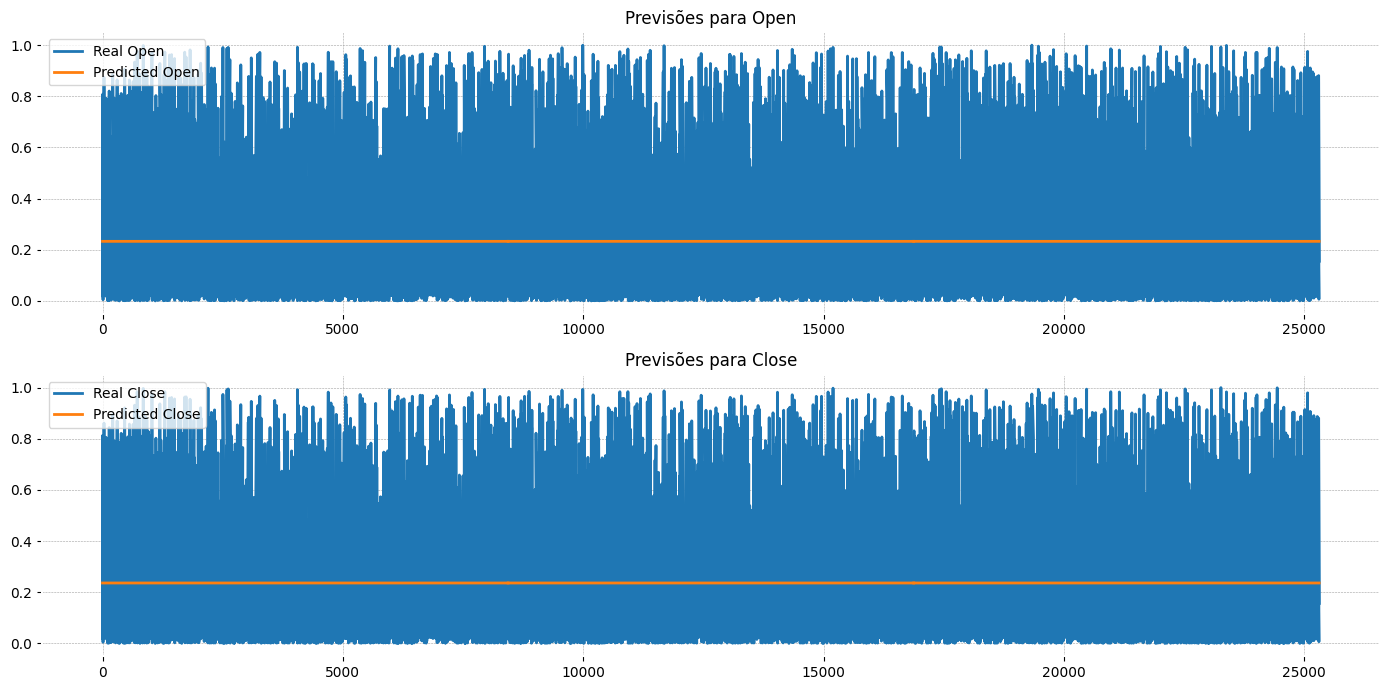

In [95]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Certifique-se de que os dados estão convertidos para tensores PyTorch
X_test_seq_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
y_test_seq_tensor = torch.tensor(y_test_seq, dtype=torch.float32)

# Fazendo previsões com o conjunto de teste
model.eval()  # Colocando o modelo em modo de avaliação
with torch.no_grad():  # Desabilitando o cálculo do gradiente durante a previsão
    predictions = model(X_test_seq_tensor)

# Desnormalizando as previsões e os valores reais
# No caso de PyTorch, as previsões são tensores, então convertemos para numpy e depois desnormalizamos.
predictions = predictions.numpy()
y_test_real = y_test_seq_tensor.numpy()

# Desnormalizando as previsões e os valores reais (se necessário, usando o scaler_y para desnormalizar)
predictions = scaler_y.inverse_transform(predictions)
y_test_real = scaler_y.inverse_transform(y_test_real)

# Calculando a Loss (Erro Quadrático Médio - MSE)
loss = np.mean((y_test_real - predictions) ** 2)

# Calculando o RQM (Root Mean Squared Error)
rmse = np.sqrt(loss)

# Exemplo: comparando a previsão para o primeiro dia do conjunto de teste
print("Previsão (Open, Close): ", predictions[0])
print("Real (Open, Close): ", y_test_real[0])

# Exibindo a Loss e o RMSE
print(f"Loss (MSE): {loss}")
print(f"RMSE: {rmse}")

# Visualizando os resultados (gráfico) para ambas as variáveis 'Open' e 'Close'
plt.figure(figsize=(14, 7))

# Visualizando a previsão para 'Open'
plt.subplot(2, 1, 1)
plt.plot(y_test_real[:, 0], label="Real Open")  # Valores reais de 'Open'
plt.plot(predictions[:, 0], label="Predicted Open")  # Previsões de 'Open'
plt.legend()
plt.title('Previsões para Open')

# Visualizando a previsão para 'Close'
plt.subplot(2, 1, 2)
plt.plot(y_test_real[:, 1], label="Real Close")  # Valores reais de 'Close'
plt.plot(predictions[:, 1], label="Predicted Close")  # Previsões de 'Close'
plt.legend()
plt.title('Previsões para Close')

plt.tight_layout()
plt.show()